# Reinforcement Learning

## An Introduction to Algorithmic Trading

---

## Overview

Welcome to this Excercise. We are now going to use our new skills to build our first unsupervised learning models. In particular, we are going to use multiple methods to create a number unsupervisoed learning models such kmeans for clustering and PCA to reduce the dimensionality of or data.

---

## Introduction

We are going to start with a slightly modified version of our previously used datasets. As always we start with a universe of stock prices for the the S&P 500.

---

## Key Features

1) First use the yfinance library to download both data sets. You will be using the constituents of the S&P 500. 

2) We will then start to compute returns.



In [11]:
# We can decide whther we want to download the data or use the saved csv version of it
DOWNLOAD_DATA_FROM_API = False 
MIN_REQUIRED_NUM_OBS_PER_TICKER=100

In [12]:
# Import Libraries
import yfinance as yf
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
OMP_NUM_THREADS=2
import matplotlib.pyplot as plt

In [13]:

if DOWNLOAD_DATA_FROM_API == True:
    # Get the list of S&P 500 constituents
    sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()
    
    # Filter out Class B shares that have a '.B' in the ticker name
    sp500_tickers = [ticker for ticker in sp500_tickers if '.B' not in ticker]
    
    # Define the start and end dates for historical data
    start_date = '2000-01-01'
    end_date   = '2024-05-01'
    
    # Download historical prices for the list of ticker sp500_tickers
    historical_prices = yf.download(sp500_tickers, start=start_date, end=end_date)

    # Remove the MultiIndex and keep only the second level
    historical_prices.columns = historical_prices.columns.droplevel(0)
    
    # Filter and keep only columns where the first level of the MultiIndex is 'Adj Close'
    historical_prices  = historical_prices.loc[:, historical_prices.columns.get_level_values(0) == 'Adj Close']

    # Count non-missing values for each ticker
    ticker_counts = historical_prices.count()

    # Filter out tickers with fewer than n=MIN_REQUIRED_NUM_OBS_PER_TICKER=100 non-missing values
    valid_tickers = ticker_counts[ticker_counts >= MIN_REQUIRED_NUM_OBS_PER_TICKER].index
    
    # Filter the DataFrame based on valid tickers
    historical_prices = historical_prices[valid_tickers]
    

else:
    # Read the previously download data
    historical_prices = pd.read_csv('historical_prices.csv', index_col='Date', parse_dates=True)
    historical_prices.columns.name = 'Ticker'

In [14]:
# Count non-missing values for each ticker
ticker_counts = historical_prices.count()

# Filter out tickers with fewer than n=MIN_REQUIRED_NUM_OBS_PER_TICKER=100 non-missing values
valid_tickers = ticker_counts[ticker_counts >= MIN_REQUIRED_NUM_OBS_PER_TICKER].index

# Filter the DataFrame based on valid tickers
historical_prices = historical_prices[valid_tickers]
    

In [15]:
# Print the first 5 rows
historical_prices.head()


Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,43.613007,NaN,0.844981,NaN,NaN,8.992848,1.277778,NaN,16.274675,28.438286,...,NaN,11.505342,NaN,6.977997,18.328693,NaN,4.680301,NaN,25.027779,NaN
2000-01-04,40.281452,NaN,0.773741,NaN,NaN,8.735912,1.270833,NaN,14.909400,26.999619,...,NaN,11.073115,NaN,7.138673,17.977634,NaN,4.586222,NaN,24.666668,NaN
2000-01-05,37.782795,NaN,0.785063,NaN,NaN,8.719849,1.388889,NaN,15.204174,27.393782,...,NaN,11.659699,NaN,7.414120,18.957697,NaN,4.609740,NaN,25.138889,NaN
2000-01-06,36.344185,NaN,0.717125,NaN,NaN,9.024967,1.375000,NaN,15.328290,26.644875,...,NaN,12.205125,NaN,7.345260,19.937763,NaN,4.570544,NaN,23.777779,NaN
2000-01-07,39.372852,NaN,0.751094,NaN,NaN,9.121321,1.451389,NaN,16.072987,27.393782,...,NaN,11.803776,NaN,7.345260,19.879248,NaN,4.468626,NaN,23.513889,NaN


In [16]:
historical_prices.count()

Ticker
A       6120
AAL     4679
AAPL    6120
ABBV    2851
ABNB     851
        ... 
XYL     3156
YUM     6120
ZBH     5727
ZBRA    6120
ZTS     2830
Length: 499, dtype: int64

In [17]:
# Use the pandas info function to verify the data types of the dataframe column
historical_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6120 entries, 2000-01-03 to 2024-04-30
Columns: 499 entries, A to ZTS
dtypes: float64(499)
memory usage: 23.3 MB


In [18]:
def computingReturns(close_prices,list_of_momentums): 
    forecast=1        
    f_returns = close_prices.pct_change(forecast)            
    f_returns = f_returns.shift(-forecast)
    f_returns = pd.DataFrame(f_returns.unstack())
    name = "F_"+str(forecast)+"_d_returns"
    f_returns.rename(columns={0: name}, inplace = True)
    f_returns.reset_index(inplace = True)
    f_returns.rename(columns={'level_0':'Ticker'}, inplace=True)
    # We add the forward returns to total_returns
    total_returns = f_returns
    
    for i in list_of_momentums:   
        feature = close_prices.pct_change(i)
        feature = pd.DataFrame(feature.unstack())
        name = str(i)+"_d_returns"        
        feature.reset_index(inplace = True)
        feature.rename(columns={0: name, 'level_0':'Ticker'}, inplace = True)
        # We add each 
        total_returns = pd.merge(total_returns,feature,left_on=['Ticker', 'Date'],right_on=['Ticker', 'Date'], how='left', suffixes=('_original', 'right'))
      
    total_returns.dropna(axis=0, how='any', inplace=True) 
    total_returns.set_index(['Date', 'Ticker'], inplace=True)

    return total_returns

In [19]:
#We can choose how many momentums and which ones we want to create
list_of_momentums = [1,2] # [1,2,3,4,5,10].
#list_of_momentums = []
total_data = computingReturns(historical_prices, list_of_momentums)
total_data.head()

,,F_1_d_returns,1_d_returns,2_d_returns
Date,Ticker,,,
2000-01-05,A,-0.038076,-0.062030,-0.133681
2000-01-06,A,0.083333,-0.038076,-0.097744
2000-01-07,A,0.060577,0.083333,0.042084
2000-01-10,A,-0.013599,0.060577,0.148958
2000-01-11,A,-0.020221,-0.013599,0.046154


In [20]:
df = total_data

In [42]:
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import numpy as np
import random

In [46]:
import numpy as np
import pandas as pd
import gym

class CustomEnv(gym.Env):
    def __init__(self, df):
        super(CustomEnv, self).__init__()
        self.df = df
        self.action_space = gym.spaces.Discrete(1)  # Action space (predict F_1_d_returns)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(2,), dtype=np.float32)  # State space (1_d_returns, 2_d_returns)
        self.current_step = 0

    def reset(self):
        # Reset the environment to initial state
        self.current_step = 0
        self.state = self.df.iloc[self.current_step, 1:3].values  # Start with first row's 1_d_returns and 2_d_returns
        return self.state

    def step(self, action):
        # Take an action (not relevant here as we are predicting)
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        if done:
            next_state = self.state
        else:
            next_state = self.df.iloc[self.current_step, 1:3].values
        reward = 0  # No reward for predicting
        info = {}   # Additional information (if needed)
        return next_state, reward, done, info


In [10]:
env = CustomEnv(df)

NameError: name 'CustomEnv' is not defined

In [20]:
env.observation_space.sample()

array([0.0549803], dtype=float32)

In [21]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [22]:
states = env.observation_space.shape
actions = env.action_space.n

NameError: name 'env' is not defined

In [58]:
actions

1

In [5]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [6]:
del model 

NameError: name 'model' is not defined

In [7]:
model = build_model(states, actions)

NameError: name 'states' is not defined

In [8]:
model.summary()

NameError: name 'model' is not defined

Let's verify the correctness of returns for ticker A:

To get the first row of returns:
                    F_1_d_returns  1_d_returns
2000-01-04 	MMM 	0.028966 	   -0.039735


2000-01-03 00:00:00 	17.557297
2000-01-04 00:00:00 	16.859657
2000-01-05 00:00:00 	17.348011 	

To achieve F_1_d_returns we need to:

buy at : 2000-01-04 00:00:00 	16.859657
sell at: 2000-01-05 00:00:00 	17.348011 	

(17.348011 -16.859657)/16.859657 = 0.028965832460292704

To achieve 1_d_returns we need to:

buy at : 2000-01-03 00:00:00 	17.557297
sell at: 2000-01-04 00:00:00 	16.859657

(16.859657 -17.557297)/17.557297 = -0.03973504577612373

In [6]:
import tensorflow as tf
from keras import __version__
tf.keras.__version__ = __version__
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [20]:
# Creating our dummy vectorizing environment
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5, 100), window_size=5)
env = DummyVecEnv([env_maker])

# Initializing and training the A2C model
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=1000)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 422      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.471   |
|    explained_variance | -66      |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.00229  |
|    value_loss         | 0.00039  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 455      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.563   |
|    explained_variance | 0.268    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.0503   |
|    value_loss      

IndexError: index 25 is out of bounds for axis 0 with size 25

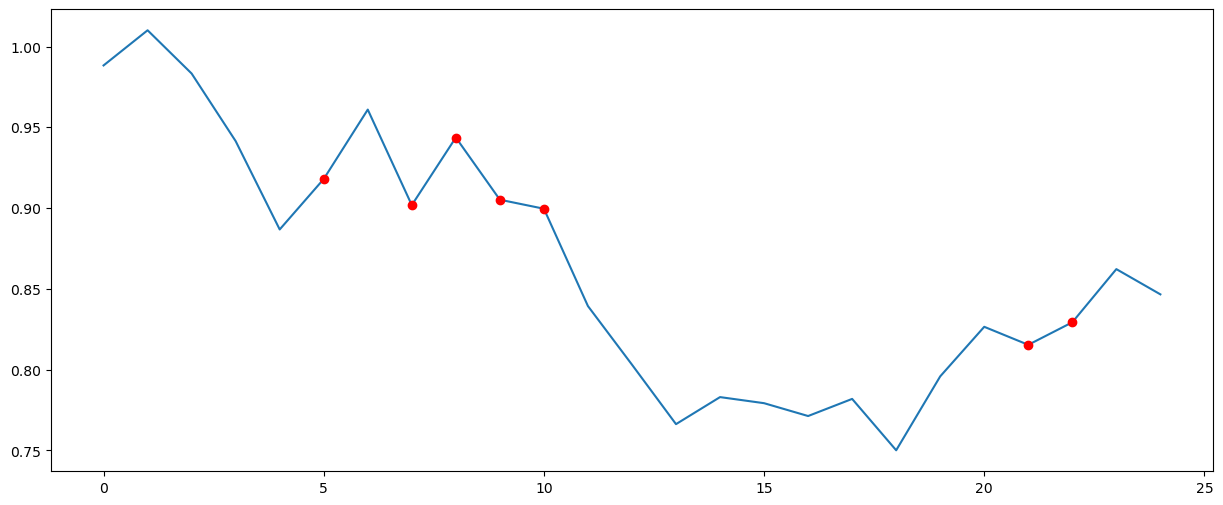

In [21]:
# Create a new environment for evaluation
env = gym.make('stocks-v0', df=df, frame_bound=(90, 110), window_size=5)
obs, _ = env.reset()
while True:
    #obs = obs[np.newaxis, ...]
    try:
        action, _states = model.predict(obs)
        obs, rewards, done, info, state1 = env.step(action)
        
        if done:
            print("info", info)
            break
    except:
        break

plt.figure(figsize=(15, 6))
plt.cla()
env.unwrapped.render_all()
plt.show()